In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from tqdm import tqdm_notebook
from multiprocessing import Pool
from collections import ChainMap
from joblib import Parallel, delayed
from scipy.special import logit, expit
from datetime import datetime
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore")
from scipy.stats import spearmanr
from collections import Counter
import json

Напишите функцию для симуляции одного прохода по всему датасету и распространения инфекции. Функция должна принимать на вход стартовый город, в котором изначально началась инфекция и вероятность распространения инфекции p. На выходе функция должна возвращать словарь, с котором ключом будет время заражения аэропорта, значением - название аэропорта. В теле функции вам нужно написать проход по всему датасету (имеет смысл использовать itertuples), где вы будете проверять, является ли текущий рейс “заразным” и если да - с вероятностью p заражать новый аэропорт.

В качестве стартовой ноды/аэропорта для симуляций можно использовать Allentown (node_id = 0)

In [2]:
#Информация по перелетам
air_traffic = pd.read_csv('events_US_air_traffic_GMT.txt', ' ')

In [3]:
air_traffic.head()

,Source,Destination,StartTime,EndTime,Duration
0,0,1,1229286900,1229291520,4620.0
1,0,1,1229272800,1229277300,4500.0
2,0,2,1229285640,1229291520,5880.0
3,0,3,1229268060,1229276040,7980.0
4,0,3,1229284740,1229293140,8400.0


In [4]:
#Информация по аэропртам и городам
airport_df = pd.read_csv('US_airport_id_info-1801-1566ad.csv')

In [5]:
airport_df.head()

,id,symbol,airport name,city,latitude,longitude,xcoordviz,ycoordviz
0,0,ABE,Lehigh Valley Intl,Allentown,40.652083,-75.440806,1.926093e+06,337357.529978
1,1,CLE,Cleveland Hopkins Intl,Cleveland,41.411689,-81.849794,1.384469e+06,302554.338074
2,2,CLT,Charlotte Douglas Intl,Charlotte,35.214000,-80.943139,1.590611e+06,-355004.415565
3,3,ORD,Chicago Ohare Intl,Chicago,41.978603,-87.904842,8.790187e+05,289127.727396
4,4,ATL,Hartsfield Jackson Atlanta Intl,Atlanta,33.636719,-84.428067,1.306257e+06,-582505.812325


In [6]:
#Общая информация
airport_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            279 non-null    int64  
 1   symbol        279 non-null    object 
 2   airport name  279 non-null    object 
 3   city          279 non-null    object 
 4   latitude      279 non-null    float64
 5   longitude     279 non-null    float64
 6   xcoordviz     279 non-null    float64
 7   ycoordviz     279 non-null    float64
dtypes: float64(4), int64(1), object(3)
memory usage: 17.6+ KB


In [7]:
#Первый рейс по времени
air_traffic['StartTime'].min()

1229231100

In [8]:
#В качестве стартовой ноды/аэропорта для симуляций можно использовать Allentown (node_id = 0)
FIRST_INFECTED_CITY = 'Allentown'

In [9]:
#Кол-во аэропортов из Allentown
airport_df[airport_df['city'] == FIRST_INFECTED_CITY]['airport name'][0]

'Lehigh Valley Intl'

In [10]:
#Первый рейс по времени из Allentown
FIRST_INFECTED_TIME = air_traffic[air_traffic['Source'] == 0]['StartTime'].min()
FIRST_INFECTED_TIME

1229245200

Вот тут видно,из Allentown (node_id = 0) это не первые рейсы в день и получается за один проход более ранние рейсы могут не зараситься никогда

In [11]:
#Проверим дубли по id
test = [k for k,v in Counter(airport_df['id']).items() if v>1]
len(test)

0

In [12]:
#Сортировка по времени 
air_traffic = air_traffic.sort_values(by=['StartTime'])

In [13]:
#Поставим время заражения пусть будет равно первому рейсу
#В качестве стартовой ноды/аэропорта для симуляций можно использовать Allentown (node_id = 0)
INFECTED_AIRPORT = {FIRST_INFECTED_TIME: airport_df[airport_df['city'] == FIRST_INFECTED_CITY]['airport name'][0]}
INFECTED_AIRPORT

{1229245200: 'Lehigh Valley Intl'}

In [14]:
#Решила взять первый по времени рейс 
#FIRST_INFECTED_TIME = int(air_traffic['StartTime'].min())
#FIRST_INFECTED_AIRPORT_NAME = str(airport_df['airport name'][airport_df['id'] == int(air_traffic[air_traffic['StartTime'] == FIRST_INFECTED_TIME]['Source'])].values[0])
#FIRST_INFECTED_AIRPORT_ID = int(air_traffic[air_traffic['StartTime'] == FIRST_INFECTED_TIME]['Source'])
#FIRST_CITY_NAME = str(airport_df['city'][airport_df['id'] == int(air_traffic[air_traffic['StartTime'] == FIRST_INFECTED_TIME]['Source'])].values[0])
#INFECTED_AIRPORT = {FIRST_INFECTED_TIME: FIRST_INFECTED_AIRPORT_NAME}

In [15]:
#Город по id аэропорта
AIROPORT_TO_CITY = airport_df[['id','city']].set_index('id')
AIROPORT_TO_CITY.head(10)

,city
id,
0,Allentown
1,Cleveland
2,Charlotte
3,Chicago
4,Atlanta
5,Detroit
6,Abilene
7,Dallas-fort Worth
8,Albuquerque


In [16]:
#Название аэропорта по id
def get_airport_name_by_id(id):
     return str(airport_df[airport_df['id'] == int(id)]['airport name'][id])

In [17]:
infected_airport = {}

Функция должна принимать на вход стартовый город, в котором изначально началась инфекция и вероятность распространения инфекции p. На выходе функция должна возвращать словарь, с котором ключом будет время заражения аэропорта, значением - название аэропорта. В теле функции вам нужно написать проход по всему датасету (имеет смысл использовать itertuples), где вы будете проверять, является ли текущий рейс “заразным” и если да - с вероятностью p заражать новый аэропорт.

In [18]:
#Функция для симуляции одного прохода по всему датасету и распространения инфекции
def infected_simulation(start_city_name, p):
    air_traffic = pd.read_csv('events_US_air_traffic_GMT.txt', ' ')
    airport_df = pd.read_csv('US_airport_id_info-1801-1566ad.csv')
    infected_airport = {}
    first_infected_airport_id = int(airport_df[airport_df['city'] == start_city_name]['id'])
    first_infected_time = int(min(air_traffic[air_traffic['Source'] == first_infected_airport_id].StartTime))
    infected_airport = {first_infected_time: get_airport_name_by_id(first_infected_airport_id)}
    i = 1
    """
    air_traffic - информация по перелетам
    airport_df - информация по аэропортам
    p - вероятность самолета заражать новый аэропорт
    np.random.random()
    """
    for flight in air_traffic.itertuples():
        if np.random.random() < p and get_airport_name_by_id(flight.Source) in infected_airport.values() and get_airport_name_by_id(flight.Destination) not in infected_airport.values():
            infected_airport[flight.EndTime] = get_airport_name_by_id(flight.Destination)
        if (flight.EndTime - first_infected_time)// (3600*12) == i:
            print("p=" + str(p) +" after " + str(12*i) + " hours, infected airoport percent:")
            print(len(infected_airport)/airport_df.id.count()*100)
            i += 1
    return infected_airport

In [19]:
infected_airport_time = infected_simulation(FIRST_INFECTED_CITY, 0.5)

p=0.5 after 12 hours, infected airoport percent:
0.7168458781362007
p=0.5 after 24 hours, infected airoport percent:
1.0752688172043012
p=0.5 after 36 hours, infected airoport percent:
86.73835125448028
p=0.5 after 48 hours, infected airoport percent:
88.17204301075269
p=0.5 after 60 hours, infected airoport percent:
96.05734767025089
p=0.5 after 72 hours, infected airoport percent:
96.05734767025089
p=0.5 after 84 hours, infected airoport percent:
97.4910394265233
p=0.5 after 96 hours, infected airoport percent:
97.4910394265233


In [20]:
#Посмотрим какие аэропорты не заразились
len(infected_airport_time)

274

In [21]:
test = [name for name in airport_df['airport name'] if name not in infected_airport_time.values()]

In [22]:
test

['Adak Airport',
 'Merle K Mudhole Smith',
 'Ithaca Tompkins Rgnl',
 'Henry E Rohlsen',
 'Telluride']

In [23]:
def get_airport_time_by_name(name):
    time = air_traffic[air_traffic['Destination'] == airport_df[airport_df['airport name'] == name]['id'].item()]['EndTime'].item()   
    return time

In [24]:
get_airport_time_by_name(str('Adak Airport')) - FIRST_INFECTED_TIME

55320

In [25]:
air_traffic[air_traffic['Destination'] == airport_df[airport_df['airport name'] == 'Telluride']['id'].item()]

,Source,Destination,StartTime,EndTime,Duration


In [26]:
air_traffic[air_traffic['Source'] == airport_df[airport_df['airport name'] == 'Telluride']['id'].item()]

,Source,Destination,StartTime,EndTime,Duration


In [27]:
#Telluride никто не летает, он не будет заражен никогда в данной моделе перелетом

Часть 2. Как инфекционность (вероятность заражения) болезни влияет на скорость распространения?
- Давайте посмотрим, насколько заразной должна быть болезнь, чтобы заразить все аэропорты в сети. Для каждой из вероятностей p=[0.01, 0.05, 0.1, 0.5, 1.] прогоните по 10 симуляций распространения, каждый раз сохраняя результаты.

- Для каждых 12 часов симуляции посчитайте, какой средний процент аэропортов от общего их числа, был заражен к этому моменту времени. Постройте графики числа зараженных городов в зависимости от времени для каждой из вероятностей.

In [28]:
def get_plot_by_hour(infected_airport_time):
    df = pd.DataFrame(list(infected_airport_time.items()),columns = ['time','name']) 
    first_infected_time = int(min(air_traffic[air_traffic['Source'] == 0].StartTime))
    df['time_hour'] = ((df['time'] - first_infected_time) // 3600)
    a = df.groupby('time_hour').size().reset_index(name='infected_in_hour')
    a = a.set_index('time_hour')
    a.plot()
    plt.show()

p=0.01 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 24 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 36 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 48 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 60 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 72 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 84 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 96 hours, infected airoport percent:
0.35842293906810035


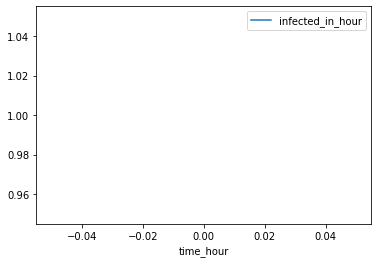

p=0.01 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 24 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 36 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 48 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 60 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 72 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 84 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 96 hours, infected airoport percent:
0.35842293906810035


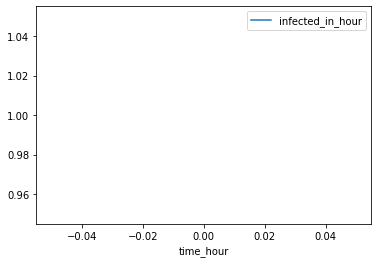

p=0.01 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 24 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 36 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 48 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 60 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 72 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 84 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 96 hours, infected airoport percent:
0.35842293906810035


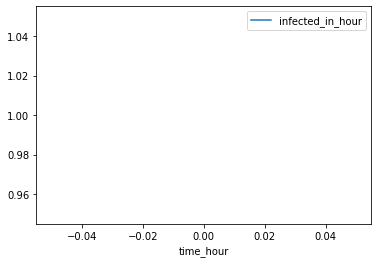

p=0.01 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 24 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 36 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 48 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 60 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 72 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 84 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 96 hours, infected airoport percent:
0.35842293906810035


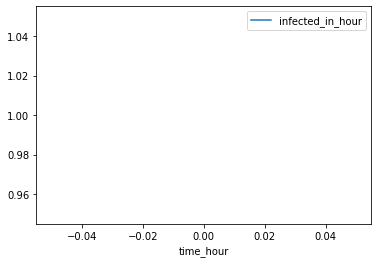

p=0.01 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 24 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 36 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 48 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 60 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 72 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 84 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 96 hours, infected airoport percent:
0.7168458781362007


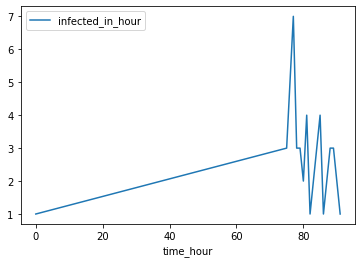

p=0.01 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 24 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 36 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 48 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 60 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 72 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 84 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 96 hours, infected airoport percent:
0.35842293906810035


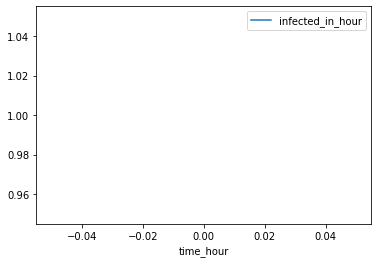

p=0.01 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 24 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 36 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 48 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 60 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 72 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 84 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 96 hours, infected airoport percent:
0.35842293906810035


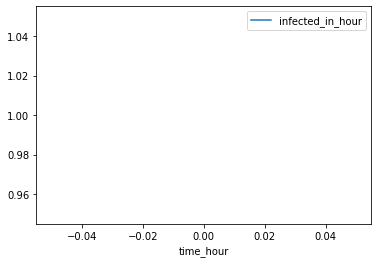

p=0.01 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 24 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 36 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 48 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 60 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 72 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 84 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 96 hours, infected airoport percent:
0.35842293906810035


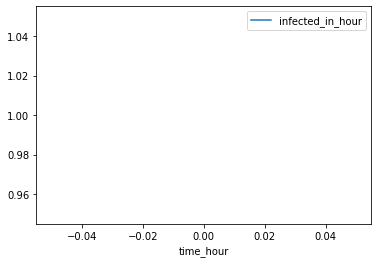

p=0.01 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 24 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 36 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 48 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 60 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 72 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 84 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 96 hours, infected airoport percent:
0.35842293906810035


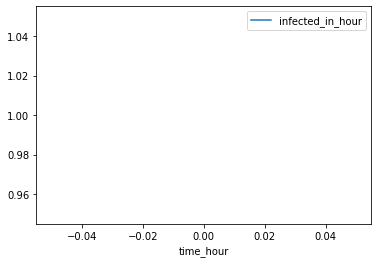

p=0.01 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 24 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 36 hours, infected airoport percent:
0.35842293906810035
p=0.01 after 48 hours, infected airoport percent:
0.7168458781362007
p=0.01 after 60 hours, infected airoport percent:
3.225806451612903
p=0.01 after 72 hours, infected airoport percent:
3.225806451612903
p=0.01 after 84 hours, infected airoport percent:
18.63799283154122
p=0.01 after 96 hours, infected airoport percent:
18.63799283154122


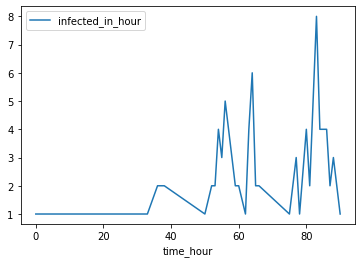

p=0.05 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.05 after 24 hours, infected airoport percent:
0.7168458781362007
p=0.05 after 36 hours, infected airoport percent:
26.16487455197133
p=0.05 after 48 hours, infected airoport percent:
27.24014336917563
p=0.05 after 60 hours, infected airoport percent:
53.40501792114696
p=0.05 after 72 hours, infected airoport percent:
53.76344086021505
p=0.05 after 84 hours, infected airoport percent:
65.59139784946237
p=0.05 after 96 hours, infected airoport percent:
65.59139784946237


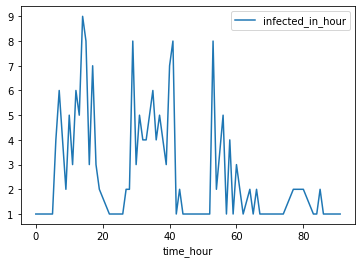

p=0.05 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.05 after 24 hours, infected airoport percent:
0.7168458781362007
p=0.05 after 36 hours, infected airoport percent:
34.76702508960574
p=0.05 after 48 hours, infected airoport percent:
34.76702508960574
p=0.05 after 60 hours, infected airoport percent:
55.91397849462365
p=0.05 after 72 hours, infected airoport percent:
56.63082437275986
p=0.05 after 84 hours, infected airoport percent:
65.94982078853047
p=0.05 after 96 hours, infected airoport percent:
65.94982078853047


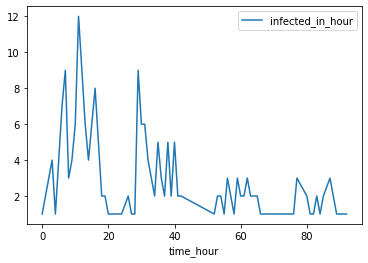

p=0.05 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.05 after 24 hours, infected airoport percent:
0.7168458781362007
p=0.05 after 36 hours, infected airoport percent:
35.483870967741936
p=0.05 after 48 hours, infected airoport percent:
35.483870967741936
p=0.05 after 60 hours, infected airoport percent:
55.91397849462365
p=0.05 after 72 hours, infected airoport percent:
56.272401433691755
p=0.05 after 84 hours, infected airoport percent:
65.59139784946237
p=0.05 after 96 hours, infected airoport percent:
65.59139784946237


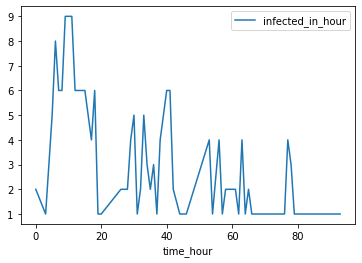

p=0.05 after 12 hours, infected airoport percent:
0.7168458781362007
p=0.05 after 24 hours, infected airoport percent:
1.0752688172043012
p=0.05 after 36 hours, infected airoport percent:
51.61290322580645
p=0.05 after 48 hours, infected airoport percent:
52.32974910394266
p=0.05 after 60 hours, infected airoport percent:
65.23297491039428
p=0.05 after 72 hours, infected airoport percent:
65.94982078853047
p=0.05 after 84 hours, infected airoport percent:
72.04301075268818
p=0.05 after 96 hours, infected airoport percent:
72.04301075268818


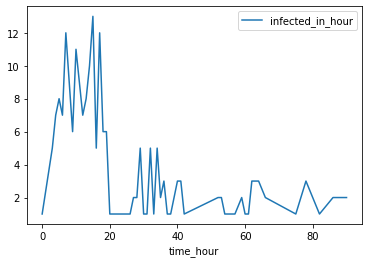

p=0.05 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.05 after 24 hours, infected airoport percent:
0.35842293906810035
p=0.05 after 36 hours, infected airoport percent:
0.35842293906810035
p=0.05 after 48 hours, infected airoport percent:
0.7168458781362007
p=0.05 after 60 hours, infected airoport percent:
51.61290322580645
p=0.05 after 72 hours, infected airoport percent:
51.971326164874554
p=0.05 after 84 hours, infected airoport percent:
64.87455197132617
p=0.05 after 96 hours, infected airoport percent:
64.87455197132617


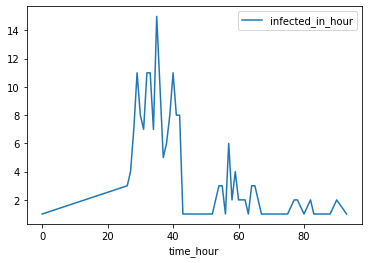

p=0.05 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.05 after 24 hours, infected airoport percent:
0.35842293906810035
p=0.05 after 36 hours, infected airoport percent:
0.35842293906810035
p=0.05 after 48 hours, infected airoport percent:
1.0752688172043012
p=0.05 after 60 hours, infected airoport percent:
30.46594982078853
p=0.05 after 72 hours, infected airoport percent:
30.824372759856633
p=0.05 after 84 hours, infected airoport percent:
53.40501792114696
p=0.05 after 96 hours, infected airoport percent:
53.40501792114696


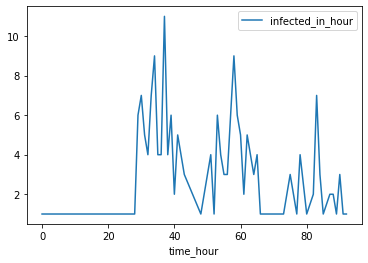

p=0.05 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.05 after 24 hours, infected airoport percent:
0.35842293906810035
p=0.05 after 36 hours, infected airoport percent:
0.35842293906810035
p=0.05 after 48 hours, infected airoport percent:
0.35842293906810035
p=0.05 after 60 hours, infected airoport percent:
0.35842293906810035
p=0.05 after 72 hours, infected airoport percent:
1.0752688172043012
p=0.05 after 84 hours, infected airoport percent:
43.01075268817204
p=0.05 after 96 hours, infected airoport percent:
43.01075268817204


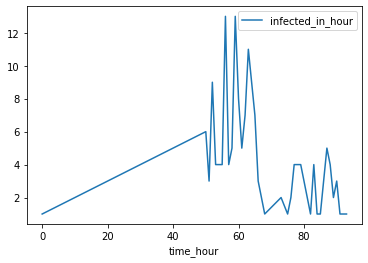

p=0.05 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.05 after 24 hours, infected airoport percent:
0.35842293906810035
p=0.05 after 36 hours, infected airoport percent:
0.35842293906810035
p=0.05 after 48 hours, infected airoport percent:
0.7168458781362007
p=0.05 after 60 hours, infected airoport percent:
45.16129032258064
p=0.05 after 72 hours, infected airoport percent:
45.16129032258064
p=0.05 after 84 hours, infected airoport percent:
62.00716845878136
p=0.05 after 96 hours, infected airoport percent:
62.00716845878136


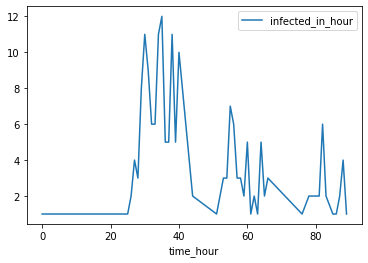

p=0.05 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.05 after 24 hours, infected airoport percent:
1.0752688172043012
p=0.05 after 36 hours, infected airoport percent:
49.10394265232975
p=0.05 after 48 hours, infected airoport percent:
49.46236559139785
p=0.05 after 60 hours, infected airoport percent:
63.08243727598566
p=0.05 after 72 hours, infected airoport percent:
63.08243727598566
p=0.05 after 84 hours, infected airoport percent:
72.04301075268818
p=0.05 after 96 hours, infected airoport percent:
72.04301075268818


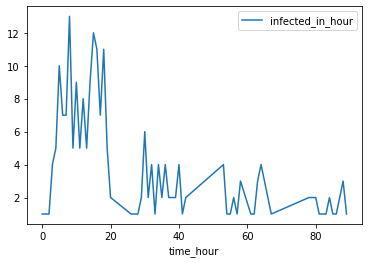

p=0.05 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.05 after 24 hours, infected airoport percent:
0.35842293906810035
p=0.05 after 36 hours, infected airoport percent:
0.35842293906810035
p=0.05 after 48 hours, infected airoport percent:
0.7168458781362007
p=0.05 after 60 hours, infected airoport percent:
31.899641577060933
p=0.05 after 72 hours, infected airoport percent:
31.899641577060933
p=0.05 after 84 hours, infected airoport percent:
56.63082437275986
p=0.05 after 96 hours, infected airoport percent:
56.63082437275986


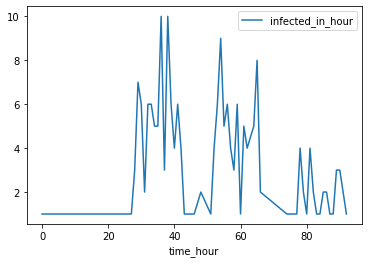

p=0.1 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.1 after 24 hours, infected airoport percent:
0.7168458781362007
p=0.1 after 36 hours, infected airoport percent:
47.31182795698925
p=0.1 after 48 hours, infected airoport percent:
47.31182795698925
p=0.1 after 60 hours, infected airoport percent:
73.11827956989248
p=0.1 after 72 hours, infected airoport percent:
73.47670250896059
p=0.1 after 84 hours, infected airoport percent:
82.07885304659499
p=0.1 after 96 hours, infected airoport percent:
82.07885304659499


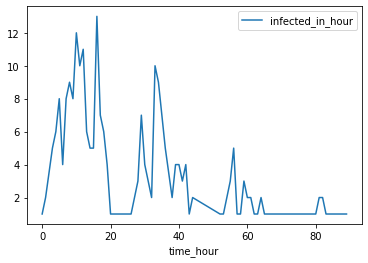

p=0.1 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.1 after 24 hours, infected airoport percent:
1.0752688172043012
p=0.1 after 36 hours, infected airoport percent:
57.70609318996416
p=0.1 after 48 hours, infected airoport percent:
57.70609318996416
p=0.1 after 60 hours, infected airoport percent:
73.11827956989248
p=0.1 after 72 hours, infected airoport percent:
73.11827956989248
p=0.1 after 84 hours, infected airoport percent:
81.72043010752688
p=0.1 after 96 hours, infected airoport percent:
81.72043010752688


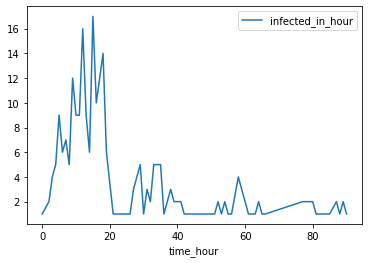

p=0.1 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.1 after 24 hours, infected airoport percent:
0.7168458781362007
p=0.1 after 36 hours, infected airoport percent:
38.35125448028674
p=0.1 after 48 hours, infected airoport percent:
39.784946236559136
p=0.1 after 60 hours, infected airoport percent:
71.68458781362007
p=0.1 after 72 hours, infected airoport percent:
72.40143369175627
p=0.1 after 84 hours, infected airoport percent:
79.92831541218638
p=0.1 after 96 hours, infected airoport percent:
79.92831541218638


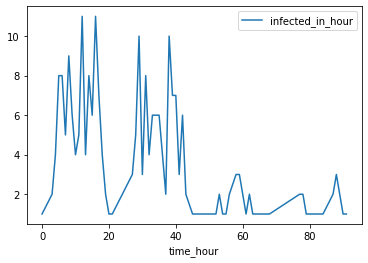

p=0.1 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.1 after 24 hours, infected airoport percent:
0.7168458781362007
p=0.1 after 36 hours, infected airoport percent:
37.992831541218635
p=0.1 after 48 hours, infected airoport percent:
38.70967741935484
p=0.1 after 60 hours, infected airoport percent:
69.89247311827957
p=0.1 after 72 hours, infected airoport percent:
69.89247311827957
p=0.1 after 84 hours, infected airoport percent:
79.92831541218638
p=0.1 after 96 hours, infected airoport percent:
79.92831541218638


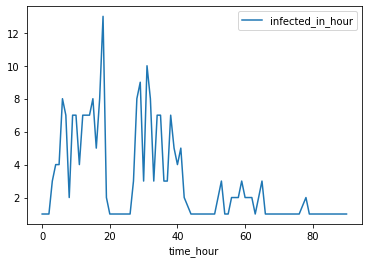

p=0.1 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.1 after 24 hours, infected airoport percent:
0.7168458781362007
p=0.1 after 36 hours, infected airoport percent:
50.89605734767025
p=0.1 after 48 hours, infected airoport percent:
50.89605734767025
p=0.1 after 60 hours, infected airoport percent:
69.17562724014337
p=0.1 after 72 hours, infected airoport percent:
69.17562724014337
p=0.1 after 84 hours, infected airoport percent:
78.85304659498208
p=0.1 after 96 hours, infected airoport percent:
78.85304659498208


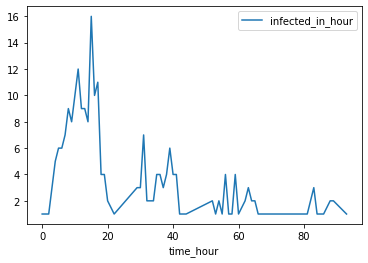

p=0.1 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.1 after 24 hours, infected airoport percent:
0.7168458781362007
p=0.1 after 36 hours, infected airoport percent:
50.179211469534046
p=0.1 after 48 hours, infected airoport percent:
51.25448028673835
p=0.1 after 60 hours, infected airoport percent:
68.81720430107528
p=0.1 after 72 hours, infected airoport percent:
69.17562724014337
p=0.1 after 84 hours, infected airoport percent:
81.00358422939068
p=0.1 after 96 hours, infected airoport percent:
81.00358422939068


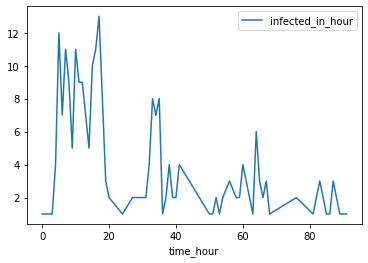

p=0.1 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.1 after 24 hours, infected airoport percent:
0.7168458781362007
p=0.1 after 36 hours, infected airoport percent:
62.365591397849464
p=0.1 after 48 hours, infected airoport percent:
63.08243727598566
p=0.1 after 60 hours, infected airoport percent:
79.92831541218638
p=0.1 after 72 hours, infected airoport percent:
79.92831541218638
p=0.1 after 84 hours, infected airoport percent:
87.09677419354838
p=0.1 after 96 hours, infected airoport percent:
87.09677419354838


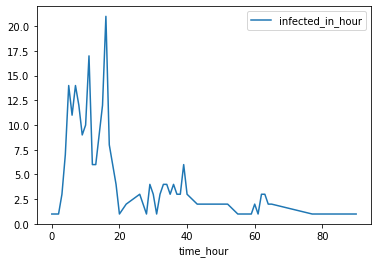

p=0.1 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.1 after 24 hours, infected airoport percent:
0.35842293906810035
p=0.1 after 36 hours, infected airoport percent:
0.35842293906810035
p=0.1 after 48 hours, infected airoport percent:
1.0752688172043012
p=0.1 after 60 hours, infected airoport percent:
49.82078853046595
p=0.1 after 72 hours, infected airoport percent:
49.82078853046595
p=0.1 after 84 hours, infected airoport percent:
70.60931899641577
p=0.1 after 96 hours, infected airoport percent:
70.60931899641577


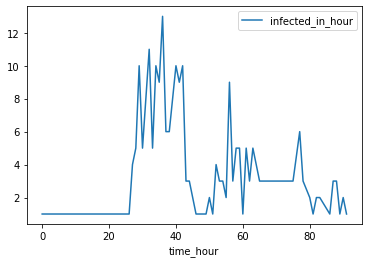

p=0.1 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.1 after 24 hours, infected airoport percent:
0.35842293906810035
p=0.1 after 36 hours, infected airoport percent:
0.35842293906810035
p=0.1 after 48 hours, infected airoport percent:
1.0752688172043012
p=0.1 after 60 hours, infected airoport percent:
64.87455197132617
p=0.1 after 72 hours, infected airoport percent:
65.23297491039428
p=0.1 after 84 hours, infected airoport percent:
78.13620071684588
p=0.1 after 96 hours, infected airoport percent:
78.13620071684588


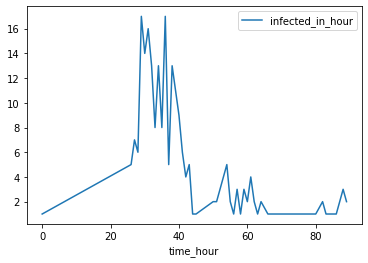

p=0.1 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.1 after 24 hours, infected airoport percent:
0.35842293906810035
p=0.1 after 36 hours, infected airoport percent:
0.35842293906810035
p=0.1 after 48 hours, infected airoport percent:
1.0752688172043012
p=0.1 after 60 hours, infected airoport percent:
56.98924731182796
p=0.1 after 72 hours, infected airoport percent:
57.70609318996416
p=0.1 after 84 hours, infected airoport percent:
73.83512544802868
p=0.1 after 96 hours, infected airoport percent:
73.83512544802868


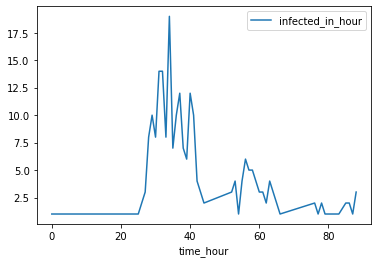

p=0.5 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.5 after 24 hours, infected airoport percent:
1.7921146953405016
p=0.5 after 36 hours, infected airoport percent:
86.37992831541219
p=0.5 after 48 hours, infected airoport percent:
87.45519713261649
p=0.5 after 60 hours, infected airoport percent:
93.9068100358423
p=0.5 after 72 hours, infected airoport percent:
94.26523297491039
p=0.5 after 84 hours, infected airoport percent:
97.1326164874552
p=0.5 after 96 hours, infected airoport percent:
97.1326164874552


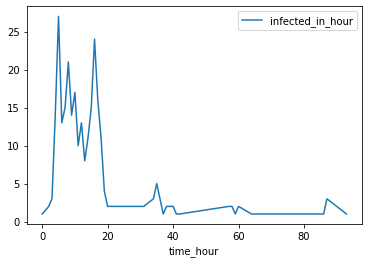

p=0.5 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.5 after 24 hours, infected airoport percent:
1.4336917562724014
p=0.5 after 36 hours, infected airoport percent:
84.22939068100358
p=0.5 after 48 hours, infected airoport percent:
86.73835125448028
p=0.5 after 60 hours, infected airoport percent:
96.7741935483871
p=0.5 after 72 hours, infected airoport percent:
97.1326164874552
p=0.5 after 84 hours, infected airoport percent:
98.9247311827957
p=0.5 after 96 hours, infected airoport percent:
98.9247311827957


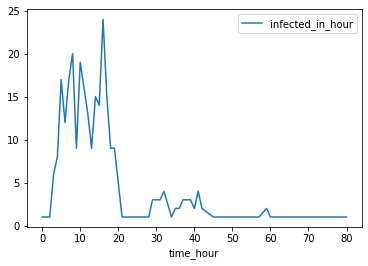

p=0.5 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.5 after 24 hours, infected airoport percent:
1.7921146953405016
p=0.5 after 36 hours, infected airoport percent:
87.09677419354838
p=0.5 after 48 hours, infected airoport percent:
88.88888888888889
p=0.5 after 60 hours, infected airoport percent:
98.2078853046595
p=0.5 after 72 hours, infected airoport percent:
98.56630824372759
p=0.5 after 84 hours, infected airoport percent:
99.2831541218638
p=0.5 after 96 hours, infected airoport percent:
99.2831541218638


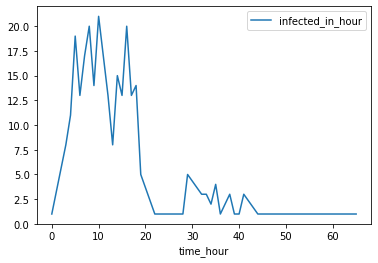

p=0.5 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.5 after 24 hours, infected airoport percent:
1.7921146953405016
p=0.5 after 36 hours, infected airoport percent:
82.79569892473118
p=0.5 after 48 hours, infected airoport percent:
84.58781362007169
p=0.5 after 60 hours, infected airoport percent:
97.84946236559139
p=0.5 after 72 hours, infected airoport percent:
97.84946236559139
p=0.5 after 84 hours, infected airoport percent:
98.56630824372759
p=0.5 after 96 hours, infected airoport percent:
98.56630824372759


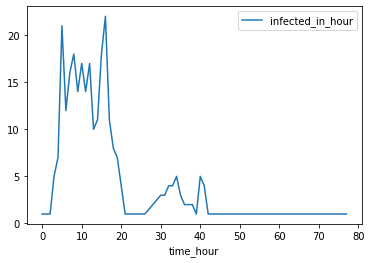

p=0.5 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.5 after 24 hours, infected airoport percent:
1.7921146953405016
p=0.5 after 36 hours, infected airoport percent:
87.09677419354838
p=0.5 after 48 hours, infected airoport percent:
88.88888888888889
p=0.5 after 60 hours, infected airoport percent:
97.1326164874552
p=0.5 after 72 hours, infected airoport percent:
97.4910394265233
p=0.5 after 84 hours, infected airoport percent:
98.56630824372759
p=0.5 after 96 hours, infected airoport percent:
98.56630824372759


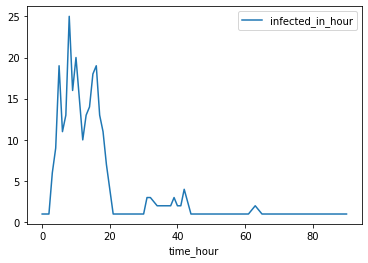

p=0.5 after 12 hours, infected airoport percent:
0.7168458781362007
p=0.5 after 24 hours, infected airoport percent:
1.4336917562724014
p=0.5 after 36 hours, infected airoport percent:
86.02150537634408
p=0.5 after 48 hours, infected airoport percent:
86.73835125448028
p=0.5 after 60 hours, infected airoport percent:
95.6989247311828
p=0.5 after 72 hours, infected airoport percent:
96.05734767025089
p=0.5 after 84 hours, infected airoport percent:
98.2078853046595
p=0.5 after 96 hours, infected airoport percent:
98.2078853046595


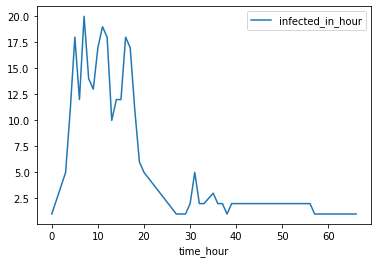

p=0.5 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.5 after 24 hours, infected airoport percent:
1.7921146953405016
p=0.5 after 36 hours, infected airoport percent:
86.02150537634408
p=0.5 after 48 hours, infected airoport percent:
87.81362007168458
p=0.5 after 60 hours, infected airoport percent:
97.4910394265233
p=0.5 after 72 hours, infected airoport percent:
97.4910394265233
p=0.5 after 84 hours, infected airoport percent:
98.2078853046595
p=0.5 after 96 hours, infected airoport percent:
98.2078853046595


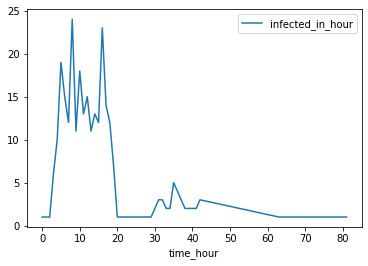

p=0.5 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.5 after 24 hours, infected airoport percent:
2.1505376344086025
p=0.5 after 36 hours, infected airoport percent:
85.66308243727599
p=0.5 after 48 hours, infected airoport percent:
87.81362007168458
p=0.5 after 60 hours, infected airoport percent:
97.1326164874552
p=0.5 after 72 hours, infected airoport percent:
97.4910394265233
p=0.5 after 84 hours, infected airoport percent:
98.9247311827957
p=0.5 after 96 hours, infected airoport percent:
98.9247311827957


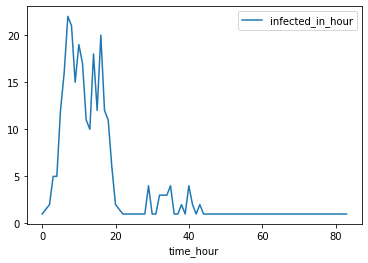

p=0.5 after 12 hours, infected airoport percent:
0.35842293906810035
p=0.5 after 24 hours, infected airoport percent:
1.7921146953405016
p=0.5 after 36 hours, infected airoport percent:
88.88888888888889
p=0.5 after 48 hours, infected airoport percent:
90.68100358422939
p=0.5 after 60 hours, infected airoport percent:
98.2078853046595
p=0.5 after 72 hours, infected airoport percent:
98.2078853046595
p=0.5 after 84 hours, infected airoport percent:
98.9247311827957
p=0.5 after 96 hours, infected airoport percent:
98.9247311827957


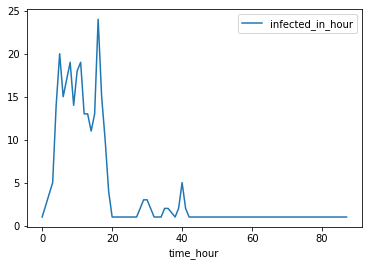

p=0.5 after 12 hours, infected airoport percent:
0.7168458781362007
p=0.5 after 24 hours, infected airoport percent:
1.4336917562724014
p=0.5 after 36 hours, infected airoport percent:
86.02150537634408
p=0.5 after 48 hours, infected airoport percent:
87.09677419354838
p=0.5 after 60 hours, infected airoport percent:
95.6989247311828
p=0.5 after 72 hours, infected airoport percent:
96.415770609319
p=0.5 after 84 hours, infected airoport percent:
98.56630824372759
p=0.5 after 96 hours, infected airoport percent:
98.56630824372759


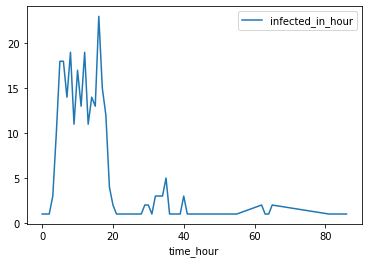

p=1.0 after 12 hours, infected airoport percent:
0.7168458781362007
p=1.0 after 24 hours, infected airoport percent:
1.7921146953405016
p=1.0 after 36 hours, infected airoport percent:
90.68100358422939
p=1.0 after 48 hours, infected airoport percent:
93.1899641577061
p=1.0 after 60 hours, infected airoport percent:
98.9247311827957
p=1.0 after 72 hours, infected airoport percent:
98.9247311827957
p=1.0 after 84 hours, infected airoport percent:
99.2831541218638
p=1.0 after 96 hours, infected airoport percent:
99.2831541218638


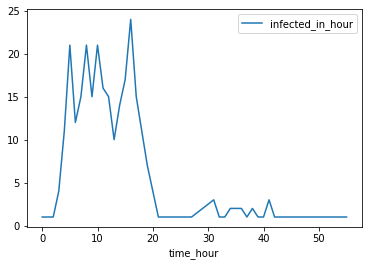

p=1.0 after 12 hours, infected airoport percent:
0.7168458781362007
p=1.0 after 24 hours, infected airoport percent:
1.7921146953405016
p=1.0 after 36 hours, infected airoport percent:
90.68100358422939
p=1.0 after 48 hours, infected airoport percent:
93.1899641577061
p=1.0 after 60 hours, infected airoport percent:
98.9247311827957
p=1.0 after 72 hours, infected airoport percent:
98.9247311827957
p=1.0 after 84 hours, infected airoport percent:
99.2831541218638
p=1.0 after 96 hours, infected airoport percent:
99.2831541218638


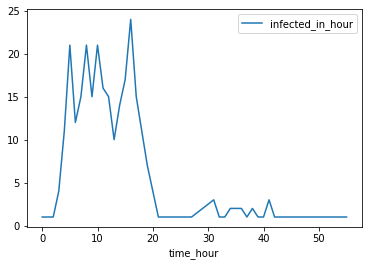

p=1.0 after 12 hours, infected airoport percent:
0.7168458781362007
p=1.0 after 24 hours, infected airoport percent:
1.7921146953405016
p=1.0 after 36 hours, infected airoport percent:
90.68100358422939
p=1.0 after 48 hours, infected airoport percent:
93.1899641577061
p=1.0 after 60 hours, infected airoport percent:
98.9247311827957
p=1.0 after 72 hours, infected airoport percent:
98.9247311827957
p=1.0 after 84 hours, infected airoport percent:
99.2831541218638
p=1.0 after 96 hours, infected airoport percent:
99.2831541218638


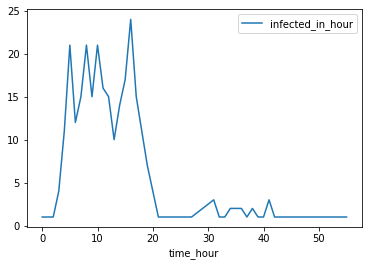

p=1.0 after 12 hours, infected airoport percent:
0.7168458781362007
p=1.0 after 24 hours, infected airoport percent:
1.7921146953405016
p=1.0 after 36 hours, infected airoport percent:
90.68100358422939
p=1.0 after 48 hours, infected airoport percent:
93.1899641577061
p=1.0 after 60 hours, infected airoport percent:
98.9247311827957
p=1.0 after 72 hours, infected airoport percent:
98.9247311827957
p=1.0 after 84 hours, infected airoport percent:
99.2831541218638
p=1.0 after 96 hours, infected airoport percent:
99.2831541218638


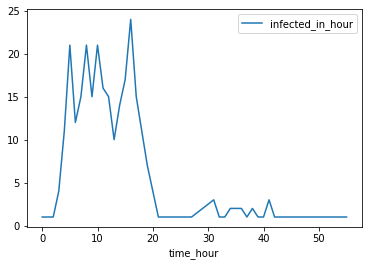

p=1.0 after 12 hours, infected airoport percent:
0.7168458781362007
p=1.0 after 24 hours, infected airoport percent:
1.7921146953405016
p=1.0 after 36 hours, infected airoport percent:
90.68100358422939
p=1.0 after 48 hours, infected airoport percent:
93.1899641577061
p=1.0 after 60 hours, infected airoport percent:
98.9247311827957
p=1.0 after 72 hours, infected airoport percent:
98.9247311827957
p=1.0 after 84 hours, infected airoport percent:
99.2831541218638
p=1.0 after 96 hours, infected airoport percent:
99.2831541218638


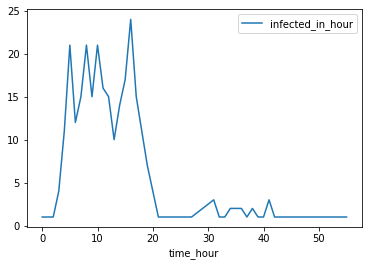

p=1.0 after 12 hours, infected airoport percent:
0.7168458781362007
p=1.0 after 24 hours, infected airoport percent:
1.7921146953405016
p=1.0 after 36 hours, infected airoport percent:
90.68100358422939
p=1.0 after 48 hours, infected airoport percent:
93.1899641577061
p=1.0 after 60 hours, infected airoport percent:
98.9247311827957
p=1.0 after 72 hours, infected airoport percent:
98.9247311827957
p=1.0 after 84 hours, infected airoport percent:
99.2831541218638
p=1.0 after 96 hours, infected airoport percent:
99.2831541218638


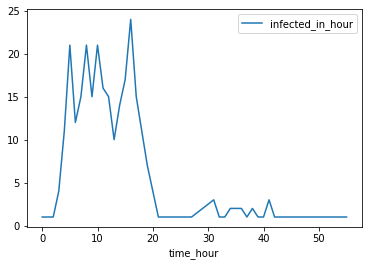

p=1.0 after 12 hours, infected airoport percent:
0.7168458781362007
p=1.0 after 24 hours, infected airoport percent:
1.7921146953405016
p=1.0 after 36 hours, infected airoport percent:
90.68100358422939
p=1.0 after 48 hours, infected airoport percent:
93.1899641577061
p=1.0 after 60 hours, infected airoport percent:
98.9247311827957
p=1.0 after 72 hours, infected airoport percent:
98.9247311827957
p=1.0 after 84 hours, infected airoport percent:
99.2831541218638
p=1.0 after 96 hours, infected airoport percent:
99.2831541218638


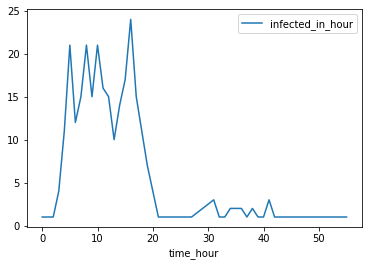

p=1.0 after 12 hours, infected airoport percent:
0.7168458781362007
p=1.0 after 24 hours, infected airoport percent:
1.7921146953405016
p=1.0 after 36 hours, infected airoport percent:
90.68100358422939
p=1.0 after 48 hours, infected airoport percent:
93.1899641577061
p=1.0 after 60 hours, infected airoport percent:
98.9247311827957
p=1.0 after 72 hours, infected airoport percent:
98.9247311827957
p=1.0 after 84 hours, infected airoport percent:
99.2831541218638
p=1.0 after 96 hours, infected airoport percent:
99.2831541218638


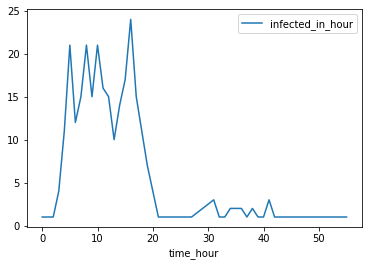

p=1.0 after 12 hours, infected airoport percent:
0.7168458781362007
p=1.0 after 24 hours, infected airoport percent:
1.7921146953405016
p=1.0 after 36 hours, infected airoport percent:
90.68100358422939
p=1.0 after 48 hours, infected airoport percent:
93.1899641577061
p=1.0 after 60 hours, infected airoport percent:
98.9247311827957
p=1.0 after 72 hours, infected airoport percent:
98.9247311827957
p=1.0 after 84 hours, infected airoport percent:
99.2831541218638
p=1.0 after 96 hours, infected airoport percent:
99.2831541218638


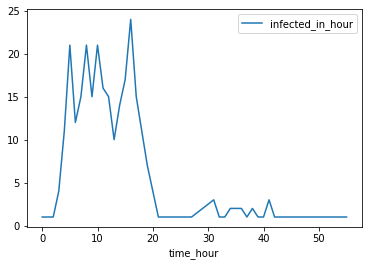

p=1.0 after 12 hours, infected airoport percent:
0.7168458781362007
p=1.0 after 24 hours, infected airoport percent:
1.7921146953405016
p=1.0 after 36 hours, infected airoport percent:
90.68100358422939
p=1.0 after 48 hours, infected airoport percent:
93.1899641577061
p=1.0 after 60 hours, infected airoport percent:
98.9247311827957
p=1.0 after 72 hours, infected airoport percent:
98.9247311827957
p=1.0 after 84 hours, infected airoport percent:
99.2831541218638
p=1.0 after 96 hours, infected airoport percent:
99.2831541218638


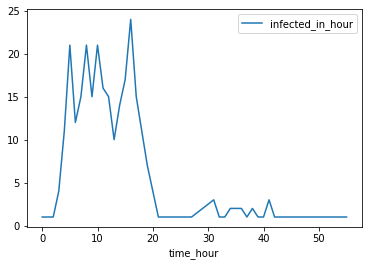

In [29]:
infected_airport_time = []
for p in [0.01, 0.05, 0.1, 0.5, 1.0]:
    for i in [1,2,3,4,5,6,7,8,9,10]:
        result_simulation = infected_simulation(FIRST_INFECTED_CITY, p)
        infected_airport_time.append({str(p):result_simulation})
        get_plot_by_hour(result_simulation)

Часть 3. Может ли информация о сети помочь предсказать, кто будет заражен?
- Настало время поработать с NetworkX. По имеющемуся датасету вам нужно построить ненаправленный граф всех аэропортов, используя относительное число перелетов между соседними аэропортами в качестве веса ребра. Например, если из аэропорта А в аэропорт Б суммарно есть 5 рейсов, из Б в А 10 рейсов, а всего в сети 150 перелетов, то вес ребра между А и Б должен быть равен (5+10)/150 = 0.1.
- Прогоните вашу симуляцию 50 раз, используя p=0.5 и стартовый аэропорт Allentown, каждый раз сохраняя результаты. Используя данные симуляций посчитайте медианное время до заражения каждого города
- Теперь используя построенный вами граф, для каждого города посчитайте его коэффициент кластеризации (nx.clustering), степень (nx.degree) и центральность (nx.betweenness_centrality)
- Наконец, постройте scatter-plot-ы для медианного времени заражения и каждой из рассчитанных выше метрик. Также посчитайте коэффициент корреляции Спирмана между этими показателями и попробуйте проинтерпретировать полученные результаты. Какая из метрик графа сильнее всего скоррелирована со временем заражения? Почему?

Настало время поработать с NetworkX. По имеющемуся датасету вам нужно построить ненаправленный граф всех аэропортов, используя относительное число перелетов между соседними аэропортами в качестве веса ребра. Например, если из аэропорта А в аэропорт Б суммарно есть 5 рейсов, из Б в А 10 рейсов, а всего в сети 150 перелетов, то вес ребра между А и Б должен быть равен (5+10)/150 = 0.1.

In [30]:
#Кол-во перелетов
len(air_traffic.groupby(['Source', 'Destination']))

4016

In [31]:
total_flights = len(air_traffic)
flights_weight = ((air_traffic.groupby(['Source', 'Destination']).size() + air_traffic.groupby(['Destination', 'Source']).size())/total_flights).reset_index(name="Weight")

In [32]:
flights_weight

,Source,Destination,Weight
0,0,1,0.000347
1,0,2,0.000231
2,0,3,0.000433
3,0,4,0.000347
4,0,5,0.000318
...,...,...,...
4011,273,27,0.000462
4012,274,32,0.000462
4013,275,27,0.000289
4014,276,27,0.000636


In [33]:
airport_df[airport_df['airport name'] == 'Adak Airport']

,id,symbol,airport name,city,latitude,longitude,xcoordviz,ycoordviz
40,40,ADK,Adak Airport,Adak Island,51.878,-176.646,-4.841095e+06,3.561746e+06


In [34]:
flights_weight[flights_weight['Source'] == 40]

,Source,Destination,Weight
1971,40,41,0.000029


In [35]:
flights_weight[flights_weight['Destination'] == 40]

,Source,Destination,Weight
1978,41,40,0.000029


In [36]:
airport_df[airport_df['airport name'] == 'Telluride']

,id,symbol,airport name,city,latitude,longitude,xcoordviz,ycoordviz
278,278,TEX,Telluride,Telluride,37.953759,-107.90848,-814107.249526,-165339.105983


In [37]:
flights_weight[flights_weight['Source'] == 278]

,Source,Destination,Weight


In [38]:
flights_weight[flights_weight['Destination'] == 278]

,Source,Destination,Weight


In [39]:
flights_weight.drop(flights_weight.index[[1971,1978]], inplace=True)

In [40]:
flights_weight[flights_weight['Destination'] == 40]

,Source,Destination,Weight


In [41]:
G=nx.Graph()
G.add_weighted_edges_from(flights_weight.to_numpy())

Прогоните вашу симуляцию 50 раз, используя p=0.5 и стартовый аэропорт Allentown, каждый раз сохраняя результаты. 

In [42]:
times = np.arange(0, 50, 1)
simulation_result = []
for i in times:
    simulation_result.append(infected_simulation('Allentown', 0.5))
    print('step' + str(i))

p=0.5 after 12 hours, infected airoport percent:
0.7168458781362007
p=0.5 after 24 hours, infected airoport percent:
1.7921146953405016
p=0.5 after 36 hours, infected airoport percent:
85.30465949820788
p=0.5 after 48 hours, infected airoport percent:
87.09677419354838
p=0.5 after 60 hours, infected airoport percent:
95.6989247311828
p=0.5 after 72 hours, infected airoport percent:
96.05734767025089
p=0.5 after 84 hours, infected airoport percent:
98.56630824372759
p=0.5 after 96 hours, infected airoport percent:
98.56630824372759
step0
p=0.5 after 12 hours, infected airoport percent:
0.7168458781362007
p=0.5 after 24 hours, infected airoport percent:
1.7921146953405016
p=0.5 after 36 hours, infected airoport percent:
80.28673835125448
p=0.5 after 48 hours, infected airoport percent:
82.43727598566308
p=0.5 after 60 hours, infected airoport percent:
96.05734767025089
p=0.5 after 72 hours, infected airoport percent:
96.415770609319
p=0.5 after 84 hours, infected airoport percent:
97.491

In [43]:
#Используя данные симуляций посчитайте медианное время до заражения каждого города
from collections import defaultdict
res = defaultdict(list)
for i in simulation_result:
    for key, val in sorted(i.items()):
        res[val].append((key-FIRST_INFECTED_TIME) // 3600)
df_median_time = pd.DataFrame(columns=['airport', 'median_time_hour'])
for key, val in sorted(res.items()):
    df_median_time = df_median_time.append({'airport': key.strip(), 'median_time_hour': np.median(val)}, ignore_index=True)

In [44]:
df_median_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   airport           277 non-null    object 
 1   median_time_hour  277 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.5+ KB


In [45]:
test = []
for name in airport_df['airport name']:
    for name2 in df_median_time['airport']:
        if(name2.strip() == name.strip()):
            print(name)
            test.append(name)

Lehigh Valley Intl
Cleveland Hopkins Intl
Charlotte Douglas Intl
Chicago Ohare Intl
Hartsfield Jackson Atlanta Intl
Detroit Metro Wayne Co
Abilene Rgnl
Dallas Fort Worth Intl
Albuquerque International Sunport
Rick Husband Amarillo Intl
Baltimore Washington Intl
Dallas Love Fld
Denver Intl
El Paso Intl
William P Hobby
Mc Carran Intl
Los Angeles Intl
Lubbock Preston Smith Intl
Midland Intl
Kansas City Intl
Orlando Intl
Chicago Midway Intl
Metropolitan Oakland Intl
Portland Intl
Phoenix Sky Harbor Intl
San Diego Intl
Seattle Tacoma Intl
Salt Lake City Intl
Lambert St Louis Intl
Tampa Intl
Tucson Intl
George Bush Intcntl Houston
San Francisco Intl
Washington Dulles Intl
Minneapolis St Paul Intl
Southwest Georgia Regional Airport
Waco Rgnl
Arcata
Sacramento Intl
Del Norte County Airport
Ted Stevens Anchorage Intl
Kodiak
Alexandria Intl
Augusta Rgnl At Bush Fld
Albany Intl
Fort Lauderdale Hollywood Intl
Newark Liberty Intl
Cincinnati Northern Kentucky Intl
John F Kennedy Intl
Philadelphia In

In [46]:
df_median_time.head()

,airport,median_time_hour
0,Abilene Rgnl,15.5
1,Abraham Lincoln Capital,17.0
2,Adams Fld,14.0
3,Akron Canton Regional Airport,11.5
4,Albany Intl,10.0


In [47]:
len(test)

277

In [48]:
not_infected = [name for name in airport_df['airport name'] if name not in test]
not_infected

['Adak Airport', 'Telluride']

In [49]:
#Опять эти два не заразились. Вот как тут правильнее сделать? убрать? 

Теперь используя построенный вами граф, для каждого города посчитайте его коэффициент кластеризации (nx.clustering), степень (nx.degree) и центральность (nx.betweenness_centrality)

In [50]:
def get_airport_id_name(name):
     return str(airport_df[airport_df['airport name'] == name]['id'])

In [51]:
#Коэффициент кластеризации (clustering coefficient) – степень взаимодействия между собой ближайших соседей узла, т.е. вероятность того, что ближайшие соседи узла будут связаны не только с ним, но и между собой.
#Степень, или мощность узла (degree) – это количество его связей.
#Центральность узлов (важность узлов)

In [52]:
flights_weight.head()

,Source,Destination,Weight
0,0,1,0.000347
1,0,2,0.000231
2,0,3,0.000433
3,0,4,0.000347
4,0,5,0.000318


In [53]:
flights_weight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4014 entries, 0 to 4015
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Source       4014 non-null   int64  
 1   Destination  4014 non-null   int64  
 2   Weight       4014 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 125.4 KB


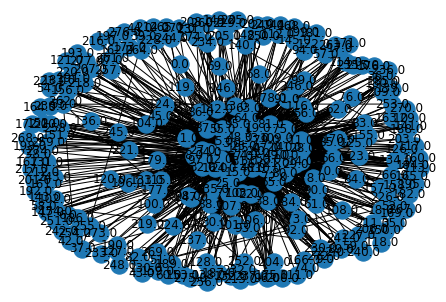

In [54]:
nx.draw(G, with_labels = True) 

In [57]:
G.number_of_nodes()

277

In [58]:
coef_clustering = nx.clustering(G)
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
median_time = df_median_time['median_time_hour'].to_dict()

Наконец, постройте scatter-plot-ы для медианного времени заражения и каждой из рассчитанных выше метрик. Также посчитайте коэффициент корреляции Спирмана между этими показателями и попробуйте проинтерпретировать полученные результаты. Какая из метрик графа сильнее всего скоррелирована со временем заражения? Почему?

In [60]:
def draw_dict_plot(d):
    lists = sorted(d.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    plt.plot(x, y)
    plt.show()

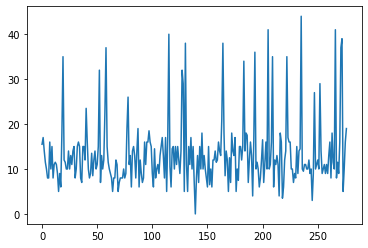

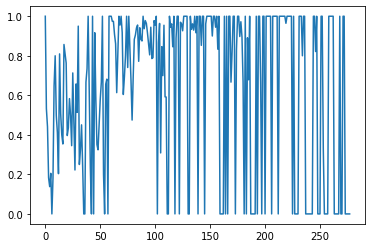

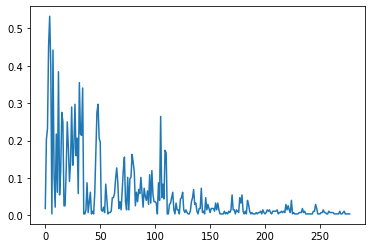

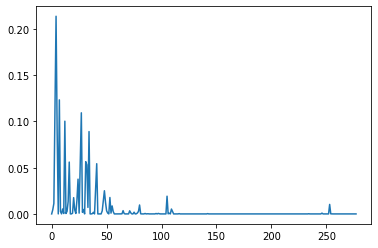

In [61]:
draw_dict_plot(median_time)
draw_dict_plot(coef_clustering)
draw_dict_plot(degree_centrality)
draw_dict_plot(betweenness_centrality)

In [62]:
df = pd.DataFrame(columns=['coef_clustering', 'degree_centrality', 'betweenness_centrality', 'median_time'])
df['coef_clustering'] = coef_clustering
df['degree_centrality'] = degree_centrality
df['betweenness_centrality'] = betweenness_centrality
df['median_time_hour'] = median_time

In [63]:
df.corr(method='spearman')

,coef_clustering,degree_centrality,betweenness_centrality,median_time_hour
coef_clustering,1.000000,1.000000,1.000000,0.674112
degree_centrality,1.000000,1.000000,1.000000,0.674112
betweenness_centrality,1.000000,1.000000,1.000000,0.674112
median_time_hour,0.674112,0.674112,0.674112,1.000000


в результате получилось, что все коэфициенты равнозначны насколько это правильно